#  <font color='blue'> Object-Oriented Multiprocessing Using MNIST Dataset </font> 
   <font color='green'> by Jack Young </font>

# <font color='blue'>ProcessPoolExecutor Class for Multiprocessing</font>
<img src="ProcessPoolExecutor.jpg" /> 
Source:  https://docs.python.org/3/library/concurrent.futures.html

## <font color='blue'> Import MNIST Data </font>
Source:  http://yann.lecun.com/exdb/mnist/

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import mnist
from datetime import datetime

# Import images and labels
images_train = mnist.train_images()
images_train_labels = mnist.train_labels()
images_test = mnist.test_images()
images_test_labels = mnist.test_labels()

# Scale testing and training images
images_test = images_test/255
images_train = images_train/255

print("Dimensions of training data:", images_train.shape)
print("Dimensions of training labels:", images_train_labels.shape, "\n")
print("Dimensions of test images:", images_test.shape)
print("Dimensions of test labels:", images_test_labels.shape)

Dimensions of training data: (60000, 28, 28)
Dimensions of training labels: (60000,) 

Dimensions of test images: (10000, 28, 28)
Dimensions of test labels: (10000,)


# <font color='blue'> Create Custom Multiprocessing Class </font>

In [47]:
import concurrent.futures

# Reuse an existing custom class stored in a separate file
import KnnClassifier as Classifier

class MultiProcess(object):
    
    # class constructor method
    def __init__(self, testingImages, testingLabels, trainingImages, trainingLabels, kSize):
        self.start_time = None
        MultiProcess.testingImages = testingImages
        MultiProcess.testingLabels = testingLabels
        MultiProcess.trainingImages = trainingImages
        MultiProcess.trainingLabels = trainingLabels
        MultiProcess.kSize = kSize     
    
    # Public facing method to predict labels for MNIST data
    def invokeMultiProcessMethod(self, numProcesses, intervalSize):       
        maxNum = MultiProcess.testingImages.shape[0]       
        tupList = self.__getInput(maxNum, intervalSize)
        print("Input work items:  ", tupList)        
        predictedLabels = self.__main(tupList, numProcesses)
        self.__reportResults(predictedLabels, maxNum, numProcesses)          
    
    # Invoke KNN classifier (class file KnnClassifier.py )
    @staticmethod 
    def _testMethod(item):       
        intermediateResult = Classifier.KnnClassifier.knn(item, 
                                                   MultiProcess.testingImages, 
                                                   MultiProcess.trainingImages, 
                                                   MultiProcess.trainingLabels, 
                                                   MultiProcess.kSize)
        return intermediateResult
    
     # Method to invoke multiple processes for asynchronous processing
    def __main(self, tupList, numProcesses):       
        self.start_time = datetime.now()
        finalResult = []        
        with concurrent.futures.ProcessPoolExecutor(max_workers = numProcesses) as executor:
            for tupRange, label in zip(tupList, executor.map(MultiProcess._testMethod, tupList, timeout=None, chunksize=1)):               
                for item in label:                    
                    finalResult.append(item)
        return finalResult
    
    # Generate work item tuples
    def __getInput(self, size, interval):    
        arr = []       
        remainder = size % interval
        iterations = int(size/interval)
        for i in range(0,iterations):
            start = i*interval
            end = start + interval        
            arr.append((start, end)) 
        if(remainder != 0):
            arr.append((end, end + remainder))       
        return arr    
    
    # Print process parameters, total run time and classifier accuracy
    def __reportResults(self, predictedLabels, maxNum, numProcesses):
        print("Predicted Labels:  ", predictedLabels)
        end_time = datetime.now()
        diff = end_time - self.start_time
        print("Test Image Set Size: ", maxNum)
        print("Number of Processes:", numProcesses)
        print("Start Time =", 
              self.start_time.strftime('%H:%M:%S.%f'), 
              "\nEnd Time =", end_time.strftime('%H:%M:%S.%f'), 
              "\nTotal Run Time (Seconds) =", 
              diff.total_seconds())
        accuracy = Classifier.KnnClassifier.multiclass_accuracy(MultiProcess.testingLabels, predictedLabels)
        print("Classifier Accuracy (k = 1):",'{:.1%}'.format(accuracy), "\n")        

# <font color='blue'> Invoke MultiProcess Class </font>

In [48]:
myTestSize = 30
multiProcess1 = MultiProcess(testingImages=images_test[:myTestSize], 
                            testingLabels=images_test_labels[:myTestSize],
                            trainingImages=images_train, 
                            trainingLabels=images_train_labels, 
                            kSize = 1)
multiProcess1.invokeMultiProcessMethod(numProcesses=2, intervalSize=2)

Input work items:   [(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10, 12), (12, 14), (14, 16), (16, 18), (18, 20), (20, 22), (22, 24), (24, 26), (26, 28), (28, 30)]
Predicted Labels:   [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1]
Test Image Set Size:  30
Number of Processes: 2
Start Time = 03:22:43.466845 
End Time = 03:23:08.686938 
Total Run Time (Seconds) = 25.220093
Classifier Accuracy (k = 1): 100.0% 



# <font color='blue'> MNIST Processing Times (test size = 200 images) </font>

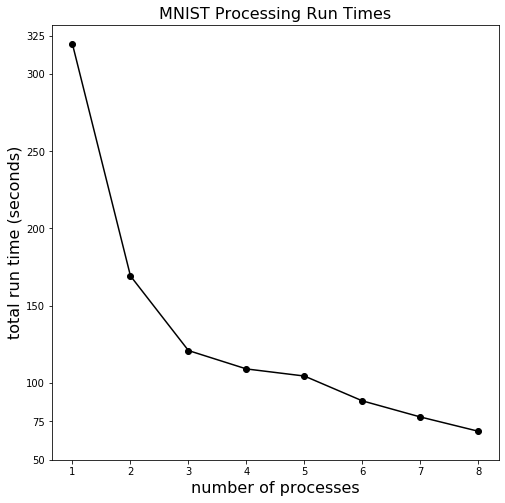

In [43]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1,2,3,4,5,6,7,8])
y = np.array([319.344205, 169.17312, 120.814834, 108.900603, 104.297465, 88.207259, 77.768724, 68.507207])
plt.figure(figsize=(8,8));
plt.plot(x, y, '-ok')
plt.xlabel('number of processes', fontsize=16);
plt.ylabel('total run time (seconds)', fontsize=16);
plt.title(label="MNIST Processing Run Times", fontsize=16);
plt.yticks([50, 75, 100, 150, 200, 250, 300, 325]);